In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr

# 1. Data Importing

In [2]:
import yfinance as yf

# Define ticker and data range
ticker='MSFT'
start='2008-12-12'
end='2025-10-4'

df=yf.download(ticker,start,end)
df.head()

/tmp/ipython-input-700716151.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(ticker,start,end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2008-12-12,14.163342,14.521815,13.680501,14.009710,78112600
2008-12-15,13.929242,14.221873,13.819504,14.148715,59925900
2008-12-16,14.712032,14.763243,13.899980,14.053611,97688700
2008-12-17,14.382816,14.668131,14.265764,14.492553,78922700
2008-12-18,14.119457,14.646194,13.892668,14.529142,80759200


# 2. Data Preprocessing

In [3]:
df.columns=['Close','High','Low','Open','Volume']
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2008-12-12,14.163342,14.521815,13.680501,14.009710,78112600
2008-12-15,13.929242,14.221873,13.819504,14.148715,59925900
2008-12-16,14.712032,14.763243,13.899980,14.053611,97688700
2008-12-17,14.382816,14.668131,14.265764,14.492553,78922700
2008-12-18,14.119457,14.646194,13.892668,14.529142,80759200


In [4]:
df=df.reset_index()
df.head()

,Date,Close,High,Low,Open,Volume
0,2008-12-12,14.163342,14.521815,13.680501,14.009710,78112600
1,2008-12-15,13.929242,14.221873,13.819504,14.148715,59925900
2,2008-12-16,14.712032,14.763243,13.899980,14.053611,97688700
3,2008-12-17,14.382816,14.668131,14.265764,14.492553,78922700
4,2008-12-18,14.119457,14.646194,13.892668,14.529142,80759200


In [5]:
df=df.drop(['Date'],axis=1)
df.head()

,Close,High,Low,Open,Volume
0,14.163342,14.521815,13.680501,14.009710,78112600
1,13.929242,14.221873,13.819504,14.148715,59925900
2,14.712032,14.763243,13.899980,14.053611,97688700
3,14.382816,14.668131,14.265764,14.492553,78922700
4,14.119457,14.646194,13.892668,14.529142,80759200


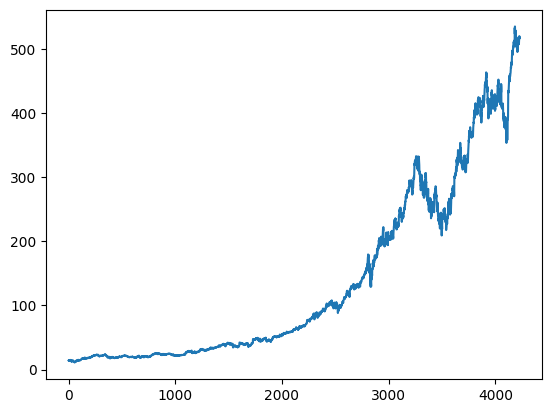

In [6]:
plt.plot(df['Close'])

# 3. Feature Engineering

In [7]:
ma100=df.rolling(100).mean()
ma200=df.rolling(200).mean()

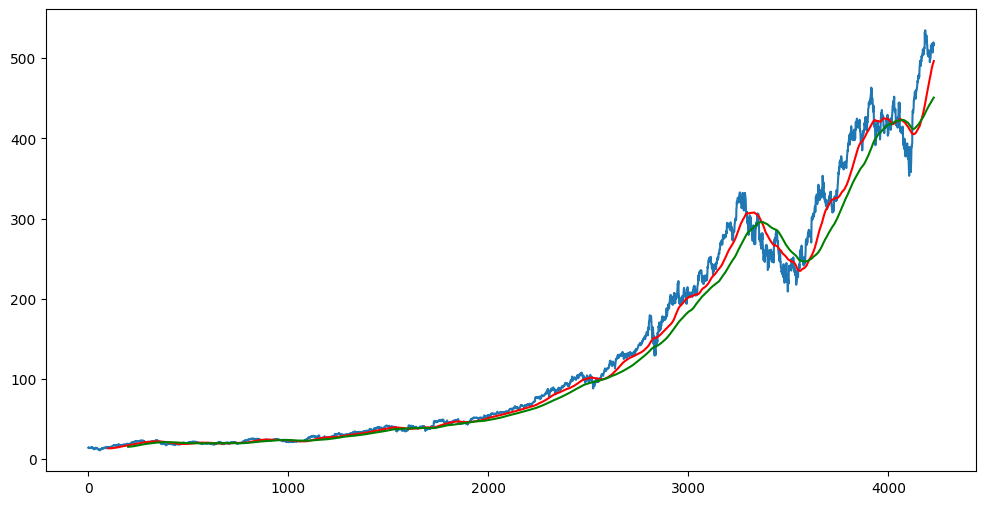

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'])
plt.plot(ma100['Close'],color='r')
plt.plot(ma200['Close'],color='g')

In [9]:
df.shape

(4228, 5)

In [10]:
training_data=df['Close'][:int(len(df)*0.7)]
testing_data=df['Close'][int(len(df)*0.7):]

training_data.shape,testing_data.shape

((2959,), (1269,))

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [12]:
transformed_training_data=scaler.fit_transform(np.array(training_data).reshape(-1,1))
transformed_testing_data=scaler.fit_transform(np.array(testing_data).reshape(-1,1))

In [13]:
x_train=[]
y_train=[]
for i in range(100,transformed_training_data.shape[0]):
  x_train.append(transformed_training_data[i-100:i])
  y_train.append(transformed_training_data[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)

# 4. Model Building

In [14]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout

model=Sequential([
    LSTM(60,return_sequences=True,input_shape=(x_train.shape[1],1)),
    Dropout(0.2),
    LSTM(60),
    Dropout(0.3),
    Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 60)        │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60)             │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,981 (171.80 KB)

 Trainable params: 43,981 (171.80 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer='adam',loss='mean_squared_error')
history=model.fit(x_train,y_train,epochs=25,batch_size=32,validation_split=0.15)

Epoch 1/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 2/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.9163e-04 - val_loss: 8.7425e-04
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3675e-04 - val_loss: 0.0030
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3698e-04 - val_loss: 8.7015e-04
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1075e-04 - val_loss: 0.0016
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1555e-04 - val_loss: 0.0052
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.5758e-04 - val_loss: 7.2736e-04
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7233e-04 - val_loss: 8.5598e-04
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9336e-04 - val_loss: 9.5436e-04
Epoch 10/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6560e-04 - val_loss: 9.4578e-04
Epoch 11/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8808e-04 - val_loss: 0.0011

In [17]:
model1=Sequential([
    LSTM(60,return_sequences=True,input_shape=(x_train.shape[1],1)),
    Dropout(0.2),
    LSTM(60),
    Dropout(0.3),
    Dense(1)
])

In [18]:
from keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
model1.compile(optimizer='adam',loss='mean_squared_error')
history1=model1.fit(x_train,y_train,epochs=25,batch_size=32,validation_split=0.15,callbacks=[early_stopping])

Epoch 1/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 2/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.7080e-04 - val_loss: 0.0029
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1433e-04 - val_loss: 0.0012
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4914e-04 - val_loss: 9.5725e-04
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4195e-04 - val_loss: 0.0011
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8979e-04 - val_loss: 0.0037
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8568e-04 - val_loss: 0.0014
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7560e-04 - val_loss: 0.0020
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7283e-04 - val_loss: 0.0018


In [19]:
model2=Sequential([
    LSTM(60,return_sequences=True,input_shape=(x_train.shape[1],1)),
    Dropout(0.2),
    LSTM(60),
    Dropout(0.3),
    Dense(1)
])

In [20]:

from keras.callbacks import EarlyStopping,ReduceLROnPlateau
early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.25)
model2.compile(optimizer='adam',loss='mean_squared_error')
history2=model2.fit(x_train,y_train,epochs=25,batch_size=32,validation_split=0.15,callbacks=[early_stopping,reduce_lr])

Epoch 1/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0060 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 2/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3246e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3593e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2097e-04 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.0626e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4703e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8081e-04 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4934e-04 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4792e-04 - val_loss: 0.0010 - learning_

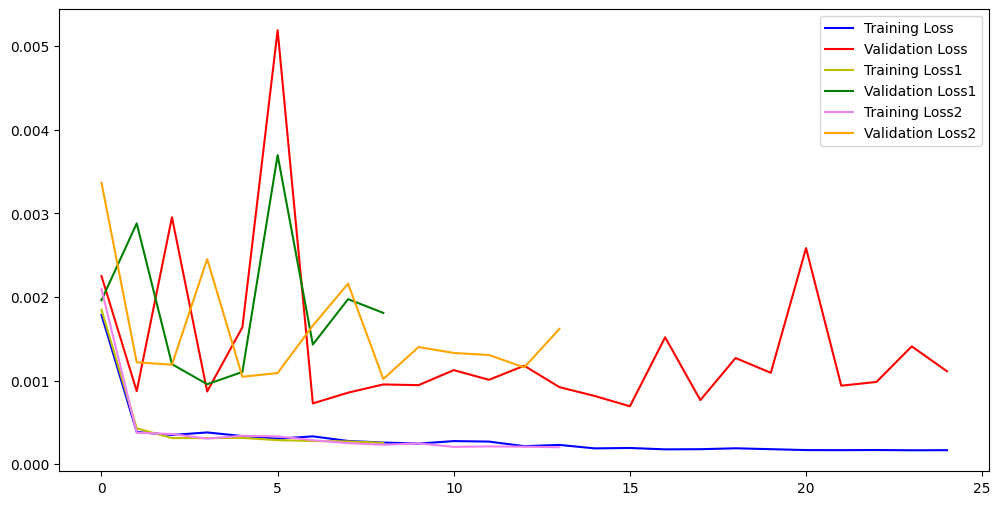

In [21]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'],label='Training Loss',color='b')
plt.plot(history.history['val_loss'],label='Validation Loss',color='r')

plt.plot(history1.history['loss'],label='Training Loss1',color='y')
plt.plot(history1.history['val_loss'],label='Validation Loss1',color='g')

plt.plot(history2.history['loss'],label='Training Loss2',color='violet')
plt.plot(history2.history['val_loss'],label='Validation Loss2',color='orange')
plt.legend()

# Experimenting with Bidirectional LSTM

In [22]:
from keras.layers import Bidirectional
model3=Sequential([
    Bidirectional(LSTM(60,return_sequences=True,input_shape=(x_train.shape[1],1))),
    Dropout(0.2),
    Bidirectional(LSTM(60)),
    Dropout(0.3),
    Dense(1)
])

In [23]:
model3.compile(optimizer='adam',loss='mean_squared_error')
history3=model3.fit(x_train,y_train,epochs=25,batch_size=32,validation_split=0.15)

Epoch 1/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 2/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.5244e-04 - val_loss: 0.0016
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.3347e-04 - val_loss: 0.0015
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2.6203e-04 - val_loss: 0.0030
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2.7185e-04 - val_loss: 0.0018
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.3965e-04 - val_loss: 9.9021e-04
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9274e-04 - val_loss: 0.0018
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.2371e-04 - val_loss: 9.2960e-04
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9166e-04 - val_loss: 9.6521e-04
Epoch 10/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9927e-04 - val_loss: 0.0044
Epoch 11/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.0152e-04 - val_loss: 7.9983e-04
Epoch 1

In [24]:
model4=Sequential([
    Bidirectional(LSTM(60,return_sequences=True,input_shape=(x_train.shape[1],1))),
    Dropout(0.2),
    Bidirectional(LSTM(60)),
    Dropout(0.3),
    Dense(1)
])

In [25]:
model4.compile(optimizer='adam',loss='mean_squared_error')
history4=model4.fit(x_train,y_train,epochs=25,batch_size=32,validation_split=0.15,callbacks=[early_stopping,reduce_lr])

Epoch 1/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0042 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 2/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.5087e-04 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.0204e-04 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.8316e-04 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.5191e-04 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6643e-04 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.3298e-04 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.5129e-04 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.9601e-04 - val_loss: 0.0021 - learning_

In [26]:
model5=Sequential([
    Bidirectional(LSTM(60,return_sequences=True,input_shape=(x_train.shape[1],1))),
    Dropout(0.2),
    Bidirectional(LSTM(60)),
    Dropout(0.3),
    Dense(1)
])

In [27]:
model5.compile(optimizer='adam',loss='mean_squared_error')
history5=model5.fit(x_train,y_train,epochs=25,batch_size=32,validation_split=0.15,callbacks=[early_stopping])

Epoch 1/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0064 - val_loss: 9.6580e-04
Epoch 2/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.0589e-04 - val_loss: 9.6360e-04
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.0026e-04 - val_loss: 9.1830e-04
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.9974e-04 - val_loss: 8.8882e-04
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.5989e-04 - val_loss: 0.0019
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.3292e-04 - val_loss: 0.0016
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9325e-04 - val_loss: 9.6776e-04
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8091e-04 - val_loss: 7.3491e-04
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0818e-04 - val_loss: 8.1524e-04
Epoch 10/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8061e-04 - val_loss: 0.0010
Epoch 11/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.7759e-04 - val_loss: 0.

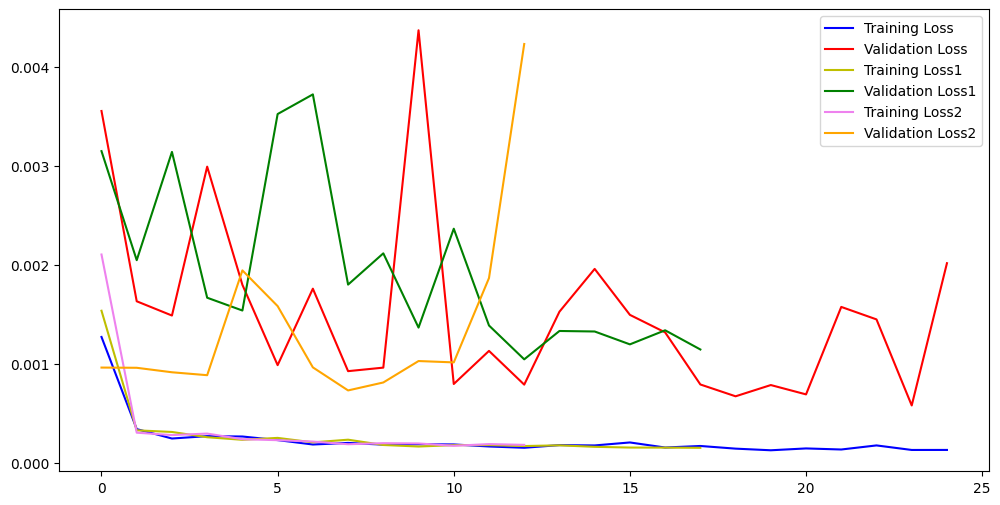

In [28]:
plt.figure(figsize=(12,6))
plt.plot(history3.history['loss'],label='Training Loss',color='b')
plt.plot(history3.history['val_loss'],label='Validation Loss',color='r')

plt.plot(history4.history['loss'],label='Training Loss1',color='y')
plt.plot(history4.history['val_loss'],label='Validation Loss1',color='g')

plt.plot(history5.history['loss'],label='Training Loss2',color='violet')
plt.plot(history5.history['val_loss'],label='Validation Loss2',color='orange')
plt.legend()

# 5. Prediction

In [29]:
last_100_days=training_data.tail(100)
final_testing_df=pd.concat([last_100_days,testing_data])

In [30]:
input_data=scaler.fit_transform(np.array(final_testing_df).reshape(-1,1))
input_data

array([[0.01212835],
       [0.01084891],
       [0.        ],
       ...,
       [0.95962594],
       [0.94897633],
       [0.95329512]])

In [31]:
x_test=[]
y_test=[]

for i in range(100,input_data.shape[0]):
  x_test.append(input_data[i-100:i])
  y_test.append(input_data[i,0])

x_test,y_test=np.array(x_test),np.array(y_test)

In [32]:
# making predictions
y_predicted=model.predict(x_test)
y_predicted1=model1.predict(x_test)
y_predicted2=model2.predict(x_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [33]:
scaler.scale_

array([0.0026825])

In [34]:
scale_factor=1/scaler.scale_[0]
y_predicted=y_predicted*scale_factor
y_predicted1=y_predicted1*scale_factor
y_predicted2=y_predicted2*scale_factor
y_test=y_test*scale_factor

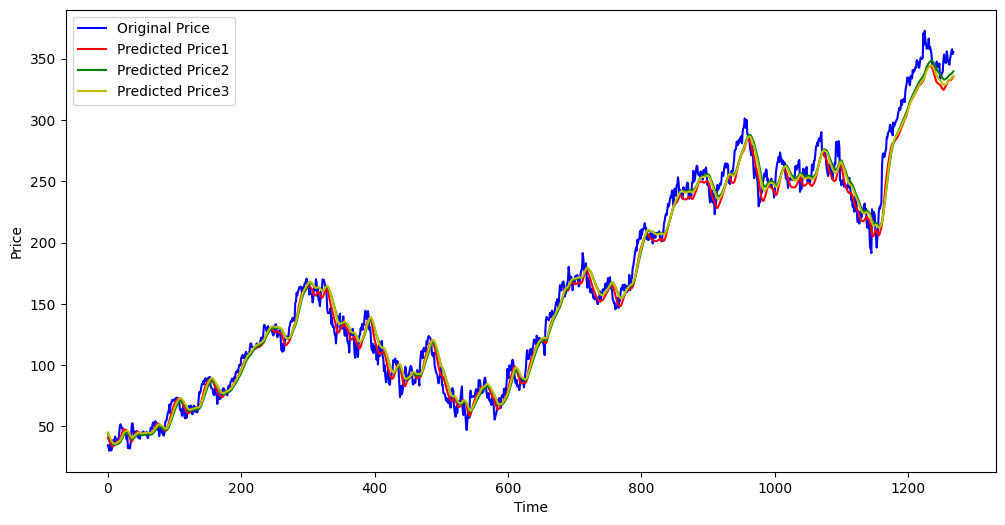

In [35]:
plt.figure(figsize=(12,6))
plt.plot(y_test,'b',label='Original Price')
plt.plot(y_predicted,'r',label='Predicted Price1')
plt.plot(y_predicted1,'g',label='Predicted Price2')
plt.plot(y_predicted2,'y',label='Predicted Price3')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

In [36]:
from sklearn.metrics import r2_score
r2_score(y_test,y_predicted),r2_score(y_test,y_predicted1),r2_score(y_test,y_predicted2)

(0.9842829477658743, 0.9821209508797731, 0.9822675435503653)

In [37]:
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
print('MAE1:',mean_absolute_error(y_test,y_predicted))
print('RMSE1:',root_mean_squared_error(y_test,y_predicted))
print('MAE2:',mean_absolute_error(y_test,y_predicted1))
print('RMSE2:',root_mean_squared_error(y_test,y_predicted1))
print('MAE3:',mean_absolute_error(y_test,y_predicted2))
print('RMSE3:',root_mean_squared_error(y_test,y_predicted2))

MAE1: 8.598647785890096
RMSE1: 10.932121080959261
MAE2: 9.321947881733875
RMSE2: 11.659799802159979
MAE3: 9.208144846996493
RMSE3: 11.611901304023117


# for Bidirectional

In [38]:
y_predicted3=model3.predict(x_test)
y_predicted4=model4.predict(x_test)
y_predicted5=model5.predict(x_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [39]:
scaler.scale_

array([0.0026825])

In [40]:
scale_factor=1/scaler.scale_[0]
y_predicted3=y_predicted3*scale_factor
y_predicted4=y_predicted4*scale_factor
y_predicted5=y_predicted5*scale_factor

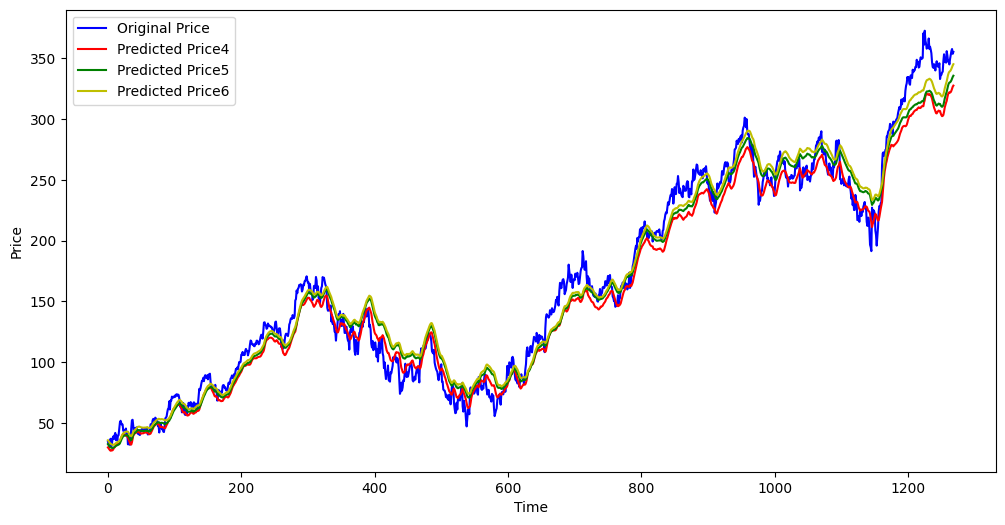

In [41]:
plt.figure(figsize=(12,6))
plt.plot(y_test,'b',label='Original Price')
plt.plot(y_predicted3,'r',label='Predicted Price4')
plt.plot(y_predicted4,'g',label='Predicted Price5')
plt.plot(y_predicted5,'y',label='Predicted Price6')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

In [42]:
r2_score(y_test,y_predicted3),r2_score(y_test,y_predicted4),r2_score(y_test,y_predicted5)

(0.9687556374215583, 0.9700269842261465, 0.9717359628365612)

In [43]:
print('MAE4:',mean_absolute_error(y_test,y_predicted3))
print('RMSE4:',root_mean_squared_error(y_test,y_predicted3))
print('MAE5:',mean_absolute_error(y_test,y_predicted4))
print('RMSE5:',root_mean_squared_error(y_test,y_predicted4))
print('MAE6:',mean_absolute_error(y_test,y_predicted5))
print('RMSE6:',root_mean_squared_error(y_test,y_predicted5))

MAE4: 12.208372860111695
RMSE4: 15.413622537875202
MAE5: 12.173582878906513
RMSE5: 15.096772344076815
MAE6: 11.768512457290466
RMSE6: 14.66006792850778


# 6.Final Evaluation

In [44]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test,y_predicted)*100,mean_absolute_percentage_error(y_test,y_predicted1)*100,mean_absolute_percentage_error(y_test,y_predicted2)*100

(6.001003547606704, 6.951131307478074, 6.814662965534331)

In [45]:
mean_absolute_percentage_error(y_test,y_predicted3)*100,mean_absolute_percentage_error(y_test,y_predicted4)*100,mean_absolute_percentage_error(y_test,y_predicted5)*100

(8.198785374397719, 8.909617162433173, 8.938164942018064)

In [ ]:
model.save('stock_prediction_LSTM.keras')